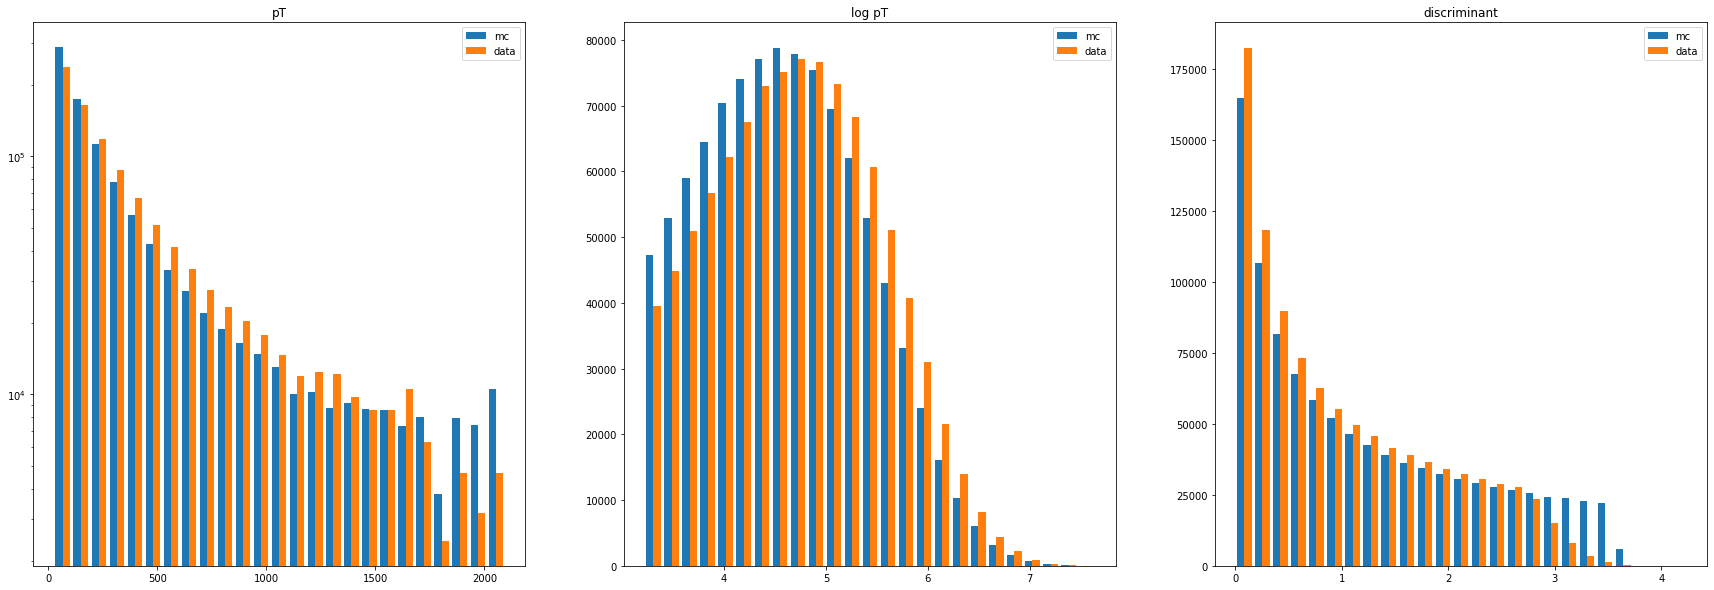

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from math import e

device='cuda'


def poly(cs, xs):
  ys = torch.zeros_like(xs)
  for (i, c) in enumerate(cs):
    ys += c * xs**i

  return ys


def discMC(xs, logpts):
  return poly([0, 0.6, 1.2, 1.1], xs) * poly([1, 0.1, -0.01], logpts)

def discData(xs, logpts):
  return poly([0, 0.7, 1.1, 1.3], xs) * poly([1, -0.1, 0.02], logpts)


def logptMC(xs):
  return torch.log(poly([25, 100, 7], -torch.log(xs)))

def logptData(xs):
  return torch.log(poly([25, 120, 5], -torch.log(xs)))



# need to add a small number to avoid values of zero.
def genMC(n):
  xs = torch.rand(n, device=device) + 1e-5
  logpts = logptMC(xs)
  ys = torch.rand(n, device=device) + 1e-5
  ds = discMC(ys, logpts)
  return torch.stack([ds, logpts]).transpose(0, 1)

def genData(n):
  xs = torch.rand(n, device=device) + 1e-5
  logpts = logptData(xs)
  ys = torch.rand(n, device=device) + 1e-5
  ds = discData(ys, logpts)
  return torch.stack([ds, logpts]).transpose(0, 1)



# give high-pT jets more weight to improve convergence
# similar idea to boosting
def ptWeight(logpts):
    pts = torch.exp(logpts)
    w = torch.exp(pts / e**5.5)
    return w / torch.mean(w)




def test(n):
  mc = genMC(n).cpu().numpy()
  data = genData(n).cpu().numpy()
    
  mcw = ptWeight(torch.tensor(mc[:,1])).numpy()
  dataw = ptWeight(torch.tensor(data[:,1])).numpy()


  plt.figure(figsize=(30, 10))

  plt.subplot(1, 3, 1)

  _ = plt.hist([np.exp(mc[:,1]), np.exp(data[:,1])], bins=25, label=["mc", "data"], weights=[mcw, dataw])
  plt.title("pT")
  plt.yscale("log")
  plt.legend()

  plt.subplot(1, 3, 2)


  _ = plt.hist([mc[:,1], data[:,1]], bins=25, label=["mc", "data"])
  plt.title("log pT")
  plt.legend()

  plt.subplot(1, 3, 3)

  _ = plt.hist([mc[:,0], data[:,0]], bins=25, label=["mc", "data"])
  plt.title("discriminant")
  plt.legend()
  plt.show()

test(int(1e6))

In [2]:
import torch.nn as nn
from collections import OrderedDict

    
    
lnlatentadv = 9


def layer(n, m, act):
  return \
    nn.Sequential(
        nn.Linear(n, m)
      , act(inplace=True)
    )


def sequential(xs):
    d = OrderedDict()
    for (i, x) in enumerate(xs):
        d[str(i)] = x
        
    return nn.Sequential(d)


def fullyConnected(nl, n0, nmid, nf, act):
  return \
    nn.Sequential(
        nn.Linear(n0, nmid)
      , act(inplace=True)
      , sequential([layer(nmid, nmid, act) for i in range(nl)])
      , nn.Linear(nmid, nf)
      )


def tloss(xs):
  return torch.mean(xs**2)




In [3]:
def save():
  torch.save(
      { 'transport_state_dict' : transport.state_dict()
      , 'adversary_state_dict' : adversary.state_dict()
      , 'toptim_state_dict' : toptim.state_dict()
      , 'aoptim_state_dict' : aoptim.state_dict()
      }
    , "./OTCalib.gaus.pth"
  )

def load():
  checkpoint = torch.load("./OTCalib.gaus.pth")
  transport.load_state_dict(checkpoint["transport_state_dict"])
  adversary.load_state_dict(checkpoint["adversary_state_dict"])
  toptim.load_state_dict(checkpoint["toptim_state_dict"])
  aoptim.load_state_dict(checkpoint["aoptim_state_dict"])

In [4]:
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.utils.tensorboard import SummaryWriter
from math import log, exp

def tonp(xs):
  return xs.cpu().detach().numpy()


def plotPtTheta(pt, toys, writer, label, epoch):
  logpt = log(pt)

  zeros = torch.zeros((toys.size()[0], nps), device=device)
  logpts = torch.ones(toys.size()[0], device=device)*logpt

  data = torch.stack([torch.sort(discData(toys, logpts))[0], logpts]).transpose(0, 1)
  mc = torch.stack([torch.sort(discMC(toys, logpts))[0], logpts]).transpose(0, 1)

  thetas = zeros.clone()
  transporting = trans(mc, thetas)
  nomtrans = tonp(transporting)
  nom = tonp(transporting + mc[:,0:1])

  postrans = []
  negtrans = []
  pos = []
  neg = []
  for i in range(nps):
    thetas = zeros.clone()
    thetas[:,i] = 1
    transporting = trans(mc, thetas)
    postrans.append(tonp(transporting))
    pos.append(tonp(transporting + mc[:,0:1])[:,0])

    thetas = zeros.clone()
    thetas[:,i] = -1
    transporting = trans(mc, thetas)
    negtrans.append(tonp(transporting))
    neg.append(tonp(transporting + mc[:,0:1])[:,0])



  data = tonp(data)
  mc = tonp(mc)

  fig = plt.figure(figsize=(6, 6))

  rangex = (0, 5)
  rangey = (-1, 1)

  h, b, _ = plt.hist( \
        [mc[:,0], nom[:,0], data[:,0]]
      , bins=25
      , range=rangex
      , density=True
      , label=["mc", "nominal transported", "data"]
      )
  
  plt.title("discriminant distribution, (pT = %0.2f)" % exp(logpt))
  plt.xlabel("discriminant")
  plt.legend()
    
  writer.add_figure("%shist" % label, fig, global_step=epoch)
  plt.close()
    
    
  cols = ["blue", "green", "red", "orange", "magenta"]

  hpos, _, _ = plt.hist( \
        pos
      , bins=b
      , range=rangex
      , density=True
      )
  
  hneg, _, _ = plt.hist( \
        neg
      , bins=b
      , range=rangex
      , density=True
      )
  

  fig = plt.figure(figsize=(6, 6))

  for (i, hvar) in enumerate(hpos):
    _ = plt.plot( \
          (b[:-1] + b[1:]) / 2.0
        , hvar - h[2]
        , linewidth=1
        , color=cols[i]
        , linestyle='dashed'
        )
    
  for (i, hvar) in enumerate(hneg):
    _ = plt.plot( \
          (b[:-1] + b[1:]) / 2.0
        , hvar - h[2]
        , linewidth=1
        , color=cols[i]
        , linestyle='dashed'
        )
    

  _ = plt.plot( \
        (b[:-1] + b[1:]) / 2.0
      , h[0] - h[2]
      , label="mc"
      , linewidth=3
      )

  _ = plt.plot( \
        (b[:-1] + b[1:]) / 2.0
      , h[1] - h[2]
      , label="nominal transported"
      , linewidth=3
      )



  plt.ylim(-0.5, 0.5)
  plt.title("discriminant difference to data, (pT = %0.2f)" % exp(logpt))
  plt.xlabel("discriminant")
  plt.ylabel("prediction - data")
  plt.legend()
    
  writer.add_figure("%sdiff" % label, fig, global_step=epoch)
  plt.close()
    


  fig = plt.figure(figsize=(6, 6))
  
  for i in range(nps):
    _ = \
      plt.plot(
          mc[:,0]
        , postrans[i]
        , c=cols[i]
      )

    _ = \
      plt.plot(
          mc[:,0]
        , negtrans[i]
        , c=cols[i]
      )


  _ = \
    plt.plot(
        mc[:,0]
      , nomtrans
      , c="black"
      , lw=4
    )


  
  plt.xlim(rangex)
  plt.ylim(rangey)
  plt.title("discriminant transport, (pT = %0.2f)" % exp(logpt))
  plt.xlabel("mc discriminant")
  plt.ylabel("transport vector")
    

        
  writer.add_figure("%strans" % label, fig, global_step=epoch)
  plt.close()
    
  return



def trans(mc, thetas):
    tmp = transport(mc)
    cv = tmp[:,0].unsqueeze(1)
    coeffs = tmp[:,1:]
    
    corr = torch.bmm(thetas.unsqueeze(1), coeffs.unsqueeze(2))
    
    # TODO
    # would this be easier to learn if it were
    # (1 - sum(thetas)) * cv + corr?
    return cv + corr.squeeze(2)
    



In [ ]:
from itertools import product

# toys for validation samples
nval = 2**15
valtoys = torch.rand(nval, device=device)


nepochs = 200
datasize = 2**18

alldata = genData(datasize)
allmc = genMC(datasize)


acts = [("lrelu", nn.LeakyReLU)] #, ("sig", nn.Sigmoid), ("tanh", nn.Tanh)]
bss = [2**n for n in [10, 12, 8]]
npss = [5]
nlayer = [4]
latent = [1024, 512, 256]
lrs = [(5e-5, 10**l) for l in [-6.5, -7, -6, -5.5]]



for ((actname, activation), batchsize, nps, nlay, nlat, (alr, tlr)) \
  in product(acts, bss, npss, nlayer, latent, lrs):
    
    nbatches = datasize // batchsize

    
    transport = fullyConnected(nlay, 2, nlat, 1+nps, activation)

    adversary = fullyConnected(3, 2, 512, 1, nn.LeakyReLU)


    transport.to(device)
    adversary.to(device)
    
    toptim = torch.optim.Adam(transport.parameters(), lr=tlr)
    aoptim = torch.optim.Adam(adversary.parameters(), lr=alr)

    writer = SummaryWriter("runs/scan5_%s_%d_%d_%d_%d_%0.2e" % (actname, batchsize, nps, nlay, nlat, tlr))


    for epoch in range(nepochs):
      radvloss = 0
      fadvloss = 0
      tadvloss = 0
      ttransloss = 0
      realavg = 0
      fakeavg = 0

      print("epoch:", epoch)

      for batch in range(nbatches):

        tmp = alldata[torch.randint(alldata.size()[0], size=(batchsize,), device=device)]
        data = tmp

        tmp = allmc[torch.randint(allmc.size()[0], size=(batchsize,), device=device)]
        mc = tmp

        toptim.zero_grad()
        aoptim.zero_grad()

        real = adversary(data)
        realavg += torch.mean(real).item()

        tmp1 = \
          binary_cross_entropy_with_logits( \
              real
            , torch.ones_like(real)
            , reduction='mean'
            , weight=ptWeight(data[:,1:])
            )

        radvloss += tmp1.item()

        # add gradient regularization
        grad_params = torch.autograd.grad(tmp1, adversary.parameters(), create_graph=True, retain_graph=True)
        grad_norm = 0
        for grad in grad_params:
            grad_norm += grad.pow(2).sum()
        grad_norm = grad_norm.sqrt()

        thetas = torch.randn((batchsize, nps), device=device)
        transporting = trans(mc, thetas)

        transported = transporting + mc[:,0:1]

        fake = adversary(torch.cat([transported, mc[:,1:]], axis=1))


        fakeavg += torch.mean(fake).item()



        tmp2 = \
          binary_cross_entropy_with_logits( \
              fake
            , torch.zeros_like(real)
            , reduction='mean'
            , weight=ptWeight(mc[:,1:])
            )

        fadvloss += tmp2.item()

        loss = tmp1 + tmp2 + 0.1*grad_norm

        loss.backward()
        aoptim.step()



        toptim.zero_grad()
        aoptim.zero_grad()

        thetas = torch.randn((batchsize, nps), device=device)
        transporting = trans(mc, thetas)

        transported = transporting + mc[:,0:1]
        fake = adversary(torch.cat([transported, mc[:,1:]], axis=1))

        tmp1 = tloss(transporting)
        ttransloss += tmp1.item()

        tmp2 = \
          binary_cross_entropy_with_logits( \
              fake
            , torch.ones_like(real)
            , reduction='mean'
            , weight=ptWeight(mc[:,1:])
            )

        tadvloss += tmp2.item()

        loss = tmp2 # tmp1 + tmp2

        loss.backward()
        toptim.step()


      # write tensorboard info once per epoch
      writer.add_scalar('radvloss', radvloss / nbatches, epoch)
      writer.add_scalar('fadvloss', fadvloss / nbatches, epoch)
      writer.add_scalar('tadvloss', tadvloss / nbatches, epoch)
      writer.add_scalar('ttransloss', ttransloss / nbatches, epoch)
      writer.add_scalar('realavg', realavg / nbatches, epoch)
      writer.add_scalar('fakeavg', fakeavg / nbatches, epoch)


      # make validation plots once per epoch
      plotPtTheta(25, valtoys, writer, "pt25", epoch)

      plotPtTheta(100, valtoys, writer, "pt100", epoch)

      plotPtTheta(500, valtoys, writer, "pt500", epoch)
    
      plotPtTheta(1000, valtoys, writer, "pt1000", epoch)

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoch: 99
epoch: 100

In [ ]:
[nn.Sigmoid(inplace=True), nn.Tanh, nn.LeakyReLU]
